## Overview
- This notebook serves as a demo for the `InSampleKnowledgeGradient` class included in `trieste_stopping`.
- The `InSampleKnowledgeGradient` acquisition function is the optimal strategy when:
    - The algorithm will stop after collecting an additional observation.
    - A solution will be returned by minimizing the posterior mean.
    - The recommended solution must be a previously queried point (i.e. "in-sample").
- In the absence of observation noise, `InSampleKnowledgeGradient` is identical to `ExpectedImprovement`.
- For more details, see Appendix B of [[Wilson, 2024]](???).

## Build a test case

In [1]:
import gpflow
import matplotlib.pyplot as plt
import tensorflow as tf
from trieste.data import Dataset
from trieste.models.gpflow import GaussianProcessRegression
from trieste.space import Box

tf.random.set_seed(0)

In [2]:
def test_function(x: tf.Tensor) -> tf.Tensor:
    return (3 * x - 1.4) * tf.sin(18 * x)

space = Box(lower=[0], upper=[1])
X = space.sample(5)
Y = test_function(X)
dataset = Dataset(X, Y)

gp = gpflow.models.GPR(
    data=(X, Y),
    kernel=gpflow.kernels.Matern52(lengthscales=0.25),
    likelihood=gpflow.likelihoods.Gaussian(variance=1e-2),  # let's see the difference between EI and KG!
)
model = GaussianProcessRegression(gp)
test_X = tf.cast(tf.linspace(0, 1, 100)[:, None], tf.float64)

## Compare acquisition functions

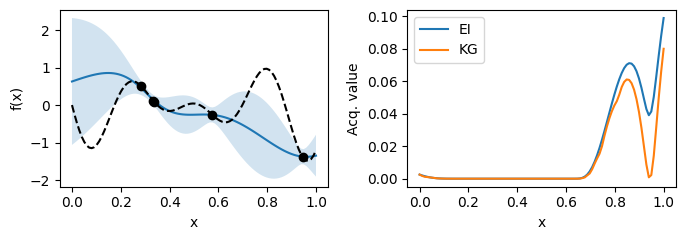

In [3]:
from trieste.acquisition import ExpectedImprovement
from trieste_stopping.acquisition import InSampleKnowledgeGradient

def plot_posterior(ax, model, points):
    means, variances = map(tf.squeeze, model.predict(points))
    stddevs = tf.sqrt(variances)
    ax.plot(points, means)
    ax.fill_between(
        tf.squeeze(points, axis=-1),
        means - 2 * tf.sqrt(variances), 
        means + 2 * tf.sqrt(variances), 
        alpha=0.2
    )

    train_set = model.get_internal_data()
    ax.scatter(train_set.query_points, train_set.observations, c="k", zorder=9)
    ax.plot(points, test_function(points), "--k", zorder=9)
    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    

fig, axes = plt.subplots(figsize=(7, 2.5), ncols=2)
plot_posterior(axes[0], model, test_X)

ei = ExpectedImprovement().prepare_acquisition_function(model=model, dataset=dataset)
kg = InSampleKnowledgeGradient().prepare_acquisition_function(model=model, dataset=dataset)

axes[1].plot(test_X, ei(test_X[:, None, :]), label="EI")
axes[1].plot(test_X, kg(test_X[:, None, :]), label="KG")
axes[1].set_xlabel("x")
axes[1].set_ylabel("Acq. value")
axes[1].legend()
fig.tight_layout()